# Text Analytics - Clustering

## Importing Necessary Packages and Loading Data

In [ ]:
# Extra installations
# pyldavis for jupyter notebook
# pip install pyldavis==2.1.2
nltk.download('wordnet')
nltk.download('names')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import csv
from datetime import datetime as dt
import pandas as pd

# for text mining
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# leave out pyLDAvis if running in Google Colab
# import pyLDAvis.gensim
# import pyLDAvis

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords, wordnet
import string

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk import word_tokenize, pos_tag, FreqDist
from nltk.corpus import reuters, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD
from random import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HotelReview = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BAP Project/Data/Hotel_Cleaned.csv")
HotelTrain = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BAP Project/Data/train_set.csv")
HotelTest = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BAP Project/Data/test_set.csv")

In [ ]:
HotelReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151319 entries, 0 to 151318
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Hotel               151319 non-null  object 
 1   Titles              151319 non-null  object 
 2   Reviews             151319 non-null  object 
 3   Dates               151319 non-null  object 
 4   Review_Rating       151319 non-null  int64  
 5   Travel_Type         151319 non-null  object 
 6   Hotel_Class         151319 non-null  float64
 7   No_of_Reviews       151319 non-null  int64  
 8   Rating              151319 non-null  float64
 9   Location            151319 non-null  float64
 10  Cleanliness         151319 non-null  float64
 11  Service             151319 non-null  float64
 12  Value               151319 non-null  float64
 13  Address             151319 non-null  object 
 14  FreeParking         151319 non-null  float64
 15  FreeWifi            151319 non-nul

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
HotelReviewPos = HotelReview[HotelReview['Sentiment'] == 'Positive']
HotelReviewNeg = HotelReview[HotelReview['Sentiment'] != 'Positive']
print("Count of Positive Review:", HotelReviewPos['Sentiment'].count())
print("Count of Negative Review:", HotelReviewNeg['Sentiment'].count())

Count of Positive Review: 138238
Count of Negative Review: 13081


## Functions for Clustering and Data Preprocessing

In [ ]:
# Topic Modelling

mystopwords=stopwords.words("english") + [
    'one','two','three','hotel','could','would','even','must','may','wa',
    'also','like','get','well', 'room']

def preprocess_text(text):
    words = [word for word in text]
    return ' '.join(words)

def cluster_texts(column, num_clusters=5):
    texts = column.tolist()
    preprocessed_texts = [preprocess_text(text) for text in texts]
    #texts = [''.join(str(word) for word in column)]
    #texts = text.tolist()
    #preprocessed_texts = [preprocess_text(text) for text in texts]
    vectorizer = TfidfVectorizer(max_df=0.8, 
                                 max_features=4000,
                                 min_df=3,
                                 stop_words=stop_words,
                                 use_idf=True)
    X = vectorizer.fit_transform(preprocessed_texts)
    kmeans = KMeans(n_clusters=num_clusters, 
                    init='k-means++', 
                    max_iter=5000, 
                    random_state=5)
    kmeans.fit(X)
    labels, counts = np.unique(kmeans.labels_[kmeans.labels_>=0], 
                               return_counts=True)

    print_top_words(X, kmeans, vectorizer, num_words=15)
    print(labels)
    print(counts)
    plot_clusters(X, kmeans)

def print_top_words(X, kmeans, vectorizer, num_words=15):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    feature_names = vectorizer.get_feature_names_out()

    for i in range(kmeans.n_clusters):
        print(f"Cluster {i}:")
        for j in range(num_words):
            print(f"{feature_names[order_centroids[i, j]]}")
        print()

def plot_clusters(X, kmeans):
    svd = TruncatedSVD(n_components=2)
    X_reduced = svd.fit_transform(X)
    labels = kmeans.labels_

    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels)
    plt.legend()
    plt.show()

In [ ]:
# compiling stopwords from hotel names and sg locations.
add_stopwords = []

# read in csv file containing location names
additional_stopwords = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BAP Project/Data/additional_stopwords.csv")
add_stopwords = additional_stopwords.values.flatten().tolist()

# removing duplicates
add_stopwords = list(set(add_stopwords))

# combining all stopwords together
stop_words = stopwords.words('english') + add_stopwords

# male and female names for more stopwords
male_names = nltk.corpus.names.words('male.txt')
male_lower = [name.lower() for name in male_names]
female_names = nltk.corpus.names.words('female.txt')
female_lower = [name.lower() for name in female_names]

# combine names, remove duplicates
english_names = set(male_lower + female_lower)

In [ ]:
# Function for further preprocessing of data
def text_preprocess(text):
    # Tokenise the text
    tokens = word_tokenize(text.lower())

    # Remove stop words and names
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in english_names]
    
    # remove further punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # removing tokens shorter than 3 characters
    tokens = [token for token in tokens if len(token) > 2]
    
    # retaining alphabetic words only
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

HotelReview['Tokens'] = [text_preprocess(tokens) for tokens in \
                         HotelReview['Reviews']]

HotelReviewPos['Tokens'] = [text_preprocess(tokens) for tokens in \
                         HotelReviewPos['Reviews']]

HotelReviewNeg['Tokens'] = [text_preprocess(tokens) for tokens in \
                         HotelReviewNeg['Reviews']]


# Function for lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Function to retain only nouns, verbs, and adjectives
def pos_tag_nouns_verbs(lemmas):
    pos_tags = nltk.pos_tag(lemmas)
    return [token for token, tag in pos_tags if \
            tag.startswith('N') or tag.startswith('V') or \
            tag.startswith('JJ')]

# Apply lemmatize function and retain N, V, and JJ
# to each row in the Tokens column
HotelReview['Lemmatized'] = HotelReview['Tokens'].apply(lemmatize_tokens)
HotelReview['Lemmatized'] = HotelReview['Lemmatized'].apply(pos_tag_nouns_verbs)

HotelReviewPos['Lemmatized'] = HotelReviewPos['Tokens'].apply(lemmatize_tokens)
HotelReviewPos['Lemmatized'] = HotelReviewPos['Lemmatized'].apply(pos_tag_nouns_verbs)

HotelReviewNeg['Lemmatized'] = HotelReviewNeg['Tokens'].apply(lemmatize_tokens)
HotelReviewNeg['Lemmatized'] = HotelReviewNeg['Lemmatized'].apply(pos_tag_nouns_verbs)

# Creating bigrams and trigrams together
def make_bigrams(documents):
    # Create bigrams
    bigram = Phrases(documents, min_count=1, threshold=5, delimiter='_')
    bigram_phraser = Phraser(bigram)
    
    # Transform documents into bigram phrases
    documents_bigrams = [bigram_phraser[doc] for doc in documents]  
    return documents_bigrams

HotelReview['Lemmatized'] = make_bigrams(HotelReview['Lemmatized'])
HotelReviewPos['Lemmatized'] = make_bigrams(HotelReviewPos['Lemmatized'])
HotelReviewNeg['Lemmatized'] = make_bigrams(HotelReviewNeg['Lemmatized'])

<ipython-input-19-1bf202260e35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HotelReviewPos['Tokens'] = [text_preprocess(tokens) for tokens in \
<ipython-input-19-1bf202260e35>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HotelReviewNeg['Tokens'] = [text_preprocess(tokens) for tokens in \
<ipython-input-19-1bf202260e35>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

## Hotel Reviews - Clustering

Full Data

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1515', '165', '1918', '1929', '30', '51', '769', '81', 'abc', 'admiralty', 'air', 'airport', 'albert', 'alexandra', 'aliwal', 'aljunied', 'aloha', 'amara', 'ambassador', 'amber', 'ametrine', 'amoy', 'amrise', 'amtd', 'anak', 'anchorvale', 'andaz', 'ang', 'ann', 'anson', 'apartment', 'apartments', 'approved', 'aqueen', 'arcadia', 'arianna', 'arton', 'arts', 'ascott', 'asia', 'asphodel', 'aspinals', 'astro', 'atrium', 'autograph', 'avenue', 'backpackers', 'bahar', 'balestier', 'bangkit', 'barat', 'basah', 'batok', 'batu', 'bay', 'bayshore', 'beach', 'bedok', 'bencoolen', 'bendemeer', 'benoi', 'beverly', 'bidadari', 'bishan', 'bliss', 'boarding', 'boat', 'boon', 'boss', 'boulevard', 'boutique', 'bras', 'brickland', 'brickworks', 'bridge', 'broadway', 'budget', 'budgetone', 'bugis', 'bukit', 'b

Cluster 0:
staff
service
excellent
time
check
food
experience
amazing
thank
day
guest
wonderful
made
team
breakfast

Cluster 1:
great
location
staff
service
food
good
breakfast
clean
excellent
place
singapore
pool
friendly
view
restaurant

Cluster 2:
small
clean
night
singapore
breakfast
good
location
place
area
bathroom
staff
day
bed
stayed
located

Cluster 3:
nice
staff
clean
good
location
breakfast
great
place
food
service
pool
friendly
view
small
restaurant

Cluster 4:
good
location
service
clean
staff
breakfast
food
place
restaurant
small
excellent
friendly
comfortable
singapore
overall

[0 1 2 3 4]
[45620 20228 51345 15677 18449]


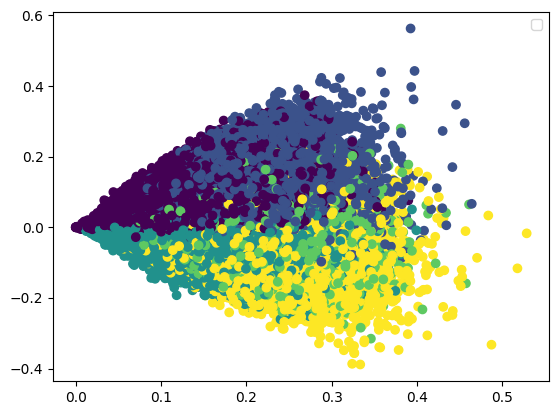

In [ ]:
cluster_texts(HotelReview['Lemmatized'], num_clusters=5)

Cluster 0:
good
location
nice
clean
service
staff
breakfast
food
place
restaurant
friendly
excellent
small
comfortable
singapore

Cluster 1:
staff
service
time
excellent
check
food
experience
day
amazing
thank
guest
breakfast
wonderful
made
friendly

Cluster 2:
small
clean
nice
night
breakfast
singapore
location
place
good
area
bathroom
staff
bed
day
located

Cluster 3:
great
location
staff
service
food
good
clean
breakfast
nice
excellent
place
pool
view
singapore
friendly

[0 1 2 3]
[21586 51573 55039 23121]


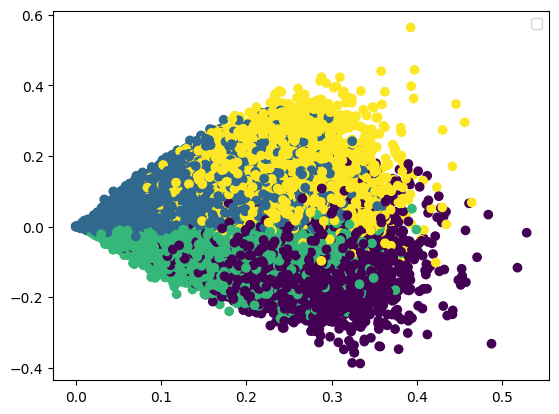

In [ ]:
cluster_texts(HotelReview['Lemmatized'], num_clusters=4)

Positive Reviews

Cluster 0:
nice
staff
clean
good
location
breakfast
great
place
pool
food
service
friendly
small
view
restaurant

Cluster 1:
good
location
service
clean
staff
breakfast
food
place
restaurant
friendly
excellent
small
comfortable
singapore
nice

Cluster 2:
great
location
staff
service
food
good
clean
breakfast
excellent
pool
place
friendly
singapore
view
restaurant

Cluster 3:
service
staff
excellent
time
thank
amazing
experience
food
check
day
team
wonderful
guest
made
friendly

Cluster 4:
small
clean
singapore
good
area
night
location
breakfast
place
staff
bathroom
located
day
mrt
stayed

[0 1 2 3 4]
[14907 16518 18735 42021 46057]


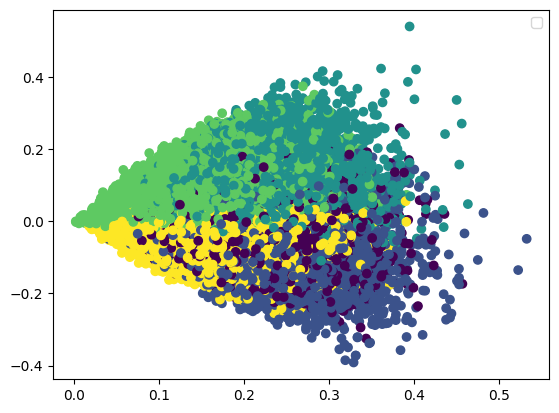

In [ ]:
cluster_texts(HotelReviewPos['Lemmatized'], num_clusters=5)

Cluster 0:
service
staff
excellent
time
thank
check
food
amazing
experience
day
wonderful
team
guest
friendly
made

Cluster 1:
small
clean
nice
singapore
area
good
breakfast
location
place
night
staff
bathroom
located
day
mrt

Cluster 2:
good
location
nice
clean
service
staff
breakfast
food
place
friendly
restaurant
excellent
small
comfortable
singapore

Cluster 3:
great
location
staff
service
food
clean
good
breakfast
nice
pool
excellent
place
view
friendly
singapore

[0 1 2 3]
[45793 51210 19777 21458]


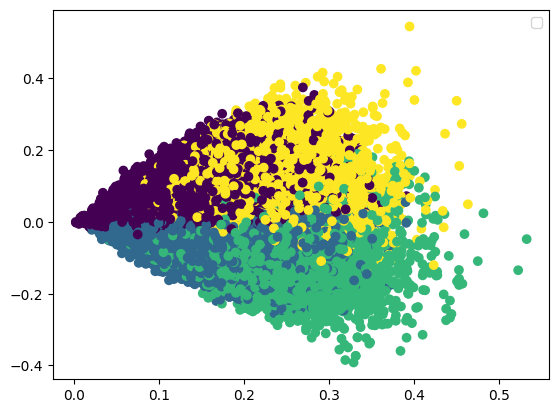

In [ ]:
cluster_texts(HotelReviewPos['Lemmatized'], num_clusters=4)

Negative Reviews

Cluster 0:
breakfast
good
small
service
staff
restaurant
day
poor
food
bad
place
clean
stayed
night
time

Cluster 1:
good
small
service
place
location
staff
singapore
food
night
day
clean
restaurant
stayed
time
bad

Cluster 2:
bed
bathroom
night
small
dirty
shower
floor
clean
window
toilet
place
day
good
stayed
got

Cluster 3:
check
staff
service
time
guest
day
said
night
front_desk
booked
hour
came
call
went
called

Cluster 4:
name
eaten
multiple
early
street
taxi
know
walk
location
flexible
flat_screen
flavour
youtube
flight
flight_stair

[0 1 2 3 4]
[1720 5951 2517 2835   58]


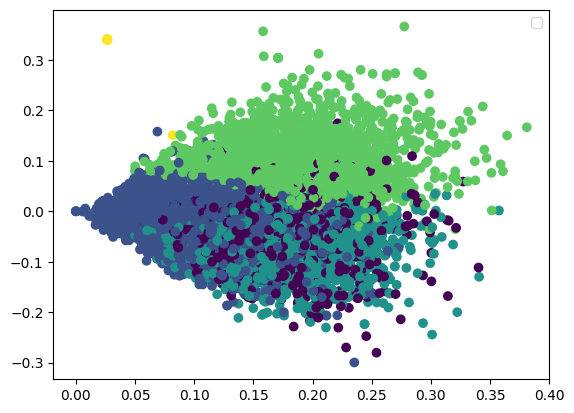

In [ ]:
cluster_texts(HotelReviewNeg['Lemmatized'], num_clusters=5)

Cluster 0:
night
good
place
bed
bathroom
clean
singapore
service
dirty
floor
stayed
location
day
staff
bad

Cluster 1:
breakfast
good
staff
service
restaurant
day
food
poor
small
bad
night
stayed
clean
place
time

Cluster 2:
check
staff
service
time
day
guest
said
night
front_desk
booked
hour
came
call
went
checked

Cluster 3:
small
bed
good
bathroom
clean
night
shower
place
toilet
area
location
staff
window
service
day

[0 1 2 3]
[6527 1688 3121 1745]


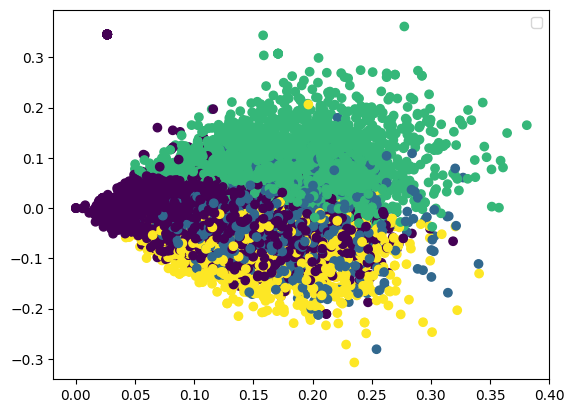

In [ ]:
cluster_texts(HotelReviewNeg['Lemmatized'], num_clusters=4)

In [ ]:
HotelReview['Lemmatized'].head()

In [ ]:
HotelReview.info()